## Vehicle Detection
### Combining CV Techniques and Machine Learning - P4

In this notebook we'll craft an object detector for finding vehicles in camera images, using a range of computer vision techniques combined with machine learning.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl
import cv2
import os
import random
import zipfile

random_state = 4126899120

In [2]:
### Notebook variables ###
extract_datasets = True # change this to True for a cold-start

In [3]:
### Define Useful notebook functions ###

# plotting function for images
def plot(images, no_rows, no_cols, width = 10., height = 4., color='gray', title = None):
    fig = plt.figure(1, (width, height))
    
    for i in range(len(images)):
        sub = fig.add_subplot(no_rows, no_cols, i + 1)
        sub.imshow(images[i], color)
        sub.axis("off")
    if (title is not None):
        plt.title(title)
    plt.show()

def convert_color(img, conv='YCrCb'):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == "YUV":
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == "HLS":
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == "HSV":
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == "RGB":
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# unzips a folder
def unzip(path, newpath):
    zfile = zipfile.ZipFile(path)
    for name in zfile.namelist():
        (dirname, filename) = os.path.split(name)
        if filename == '':
            # directory
            if not os.path.exists(os.path.join(newpath, dirname)):
                os.mkdir(os.path.join(newpath, dirname))
        else:
            # file
            with open(os.path.join(newpath, name), 'wb') as fd:
                fd.write(zfile.read(name))
    zfile.close()

In [4]:
test_image_files = os.listdir("./test_images/")
test_images = [mpimg.imread(os.path.join("./test_images/", x)) for x in test_image_files]
print(test_image_files)

['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


#### Plot sample frames from which vehicles will be detected
Show the raw data from which our vehicle detection pipeline will operate.

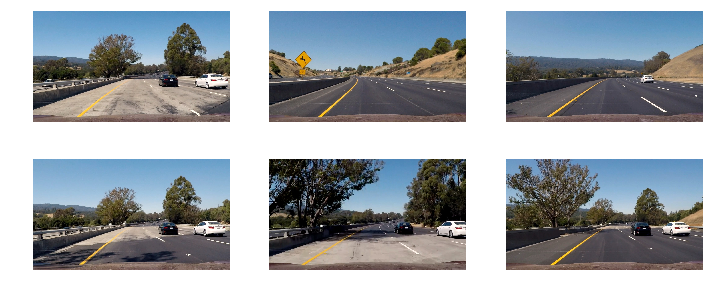

In [5]:
# Show sample image frames for which we'll detect the vehicles from.
plot(test_images, 2, 3, 12., 5.)

*As per the above examples it shows that our vehicle will be keeping in the left line with two or more cars approaching from the lanes on the right.  Because cars vary in colour, relying simply on the saturation channel is not wise...*

**Extract and load the training datasets into the notebook**

In [6]:
# Load the datasets
if (extract_datasets):
    zip_path_nonvehicles = "./data/non-vehicles.zip"
    zip_path_vehicles = "./data/vehicles.zip"
    unzip(zip_path_nonvehicles, "./data/") # unzip non-vehicles.zip
    unzip(zip_path_vehicles, "./data/") # unzip vehicles.zip

#### Plot example vehicle and non-vehicle images
Now show what the training data looks like for which we'll be using to create our vehicle detection pipeline.

In [7]:
### Define image data paths of vehicles / non-vehicles
path_nonvehicles = ["./data/non-vehicles/GTI/", "./data/non-vehicles/Extras/"]
path_vehicles = ["./data/vehicles/GTI_Far/", "./data/vehicles/GTI_Left/", "./data/vehicles/GTI_MiddleClose/", \
                 "./data/vehicles/GTI_Right/", "./data/vehicles/KITTI_extracted/"]

In [8]:
### Plot a collection of vehicles / non-vehicles
# vehicles
samples = 8

def get_batch(paths, sample_size):
    result = []
    while (len(result) <= sample_size):
        if len(result) >= sample_size:
            break
        for path in paths:
            if len(result) >= sample_size:
                break

            file = random.choice(os.listdir(path))
            img = mpimg.imread(os.path.join(path, file))
            result.append(img)
    return result

**Sample Vehicle Images**

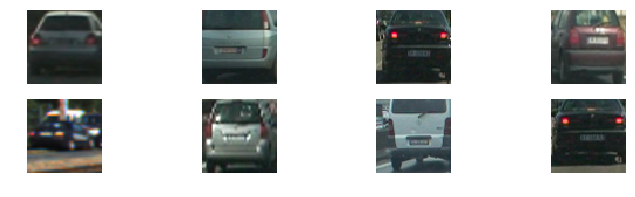

In [9]:
# vehicles
sample_vehicles = get_batch(path_vehicles, samples)
plot(sample_vehicles, 2, 4, 12., 3.)

**Sample Non-vehicle Images**

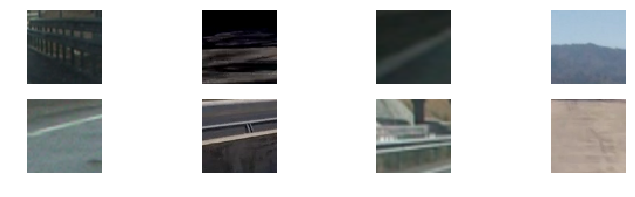

In [10]:
# non-vehicles
sample_nonvehicles = get_batch(path_nonvehicles, samples)
plot(sample_nonvehicles, 2, 4, 12., 3.)

#### Exploring the colour spaces and images
This section explores the relationship between cars and their associated colour spaces.

In [54]:
### Define Useful Colour Exploratory functions ###
def show_3dplot(img_list, colourspace = "HLS", patch_size = 64):
    pix_list = []
    col_list = []
    for img in img_list:
        #img_small = cv2.resize(img, (np.int(img.shape[1] / patch_size),  np.int(img.shape[0] / patch_size)),\
        #                      interpolation=cv2.INTER_NEAREST)
        #img_small_rgb = img_small / 255.

        conv_img = convert_color(img, colourspace)
        pix_list.append(conv_img)
        col_list.append(conv_img)
        #col_list.append(img_small_rgb)
    
    plot3d(pix_list, col_list, 1, 2, size = (12., 4.), axis_labels=list(str(colourspace[-3:])))

def plot3d(pixels_list, colors_list, no_rows, no_cols, size=(12., 12.),
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=size)
    i = 0
    for p in range(len(pixels_list)):
        (pixels, colors_rgb) = (pixels_list[p], colors_list[p])
        ax = fig.add_subplot(no_rows, no_cols, i + 1, projection='3d')
        
        # Set axis limits
        ax.set_xlim(*axis_limits[0])
        ax.set_ylim(*axis_limits[1])
        ax.set_zlim(*axis_limits[2])

        # Set axis labels and sizes
        ax.tick_params(axis='both', which='major', labelsize=12, pad=8)
        ax.set_xlabel(axis_labels[0], fontsize=14, labelpad=16)
        ax.set_ylabel(axis_labels[1], fontsize=14, labelpad=16)
        ax.set_zlabel(axis_labels[2], fontsize=14, labelpad=16)

        # Plot pixel values with colors given in colors_rgb
        ax.scatter3D(pixels[:, :, 0].ravel(),
                   pixels[:, :, 1].ravel(),
                   pixels[:, :, 2].ravel(),
                   cmap="Greens")
        i += 1
    
    plt.show()

**Show colour spaces in a 3d point cloud to prove the linear separability for solving with a machine learning model**

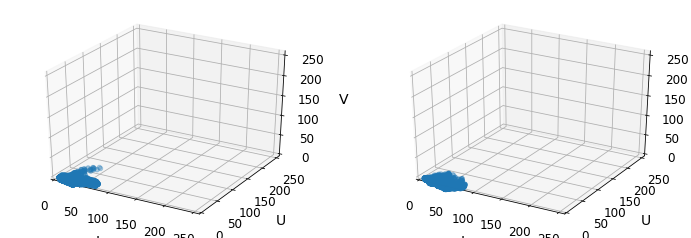

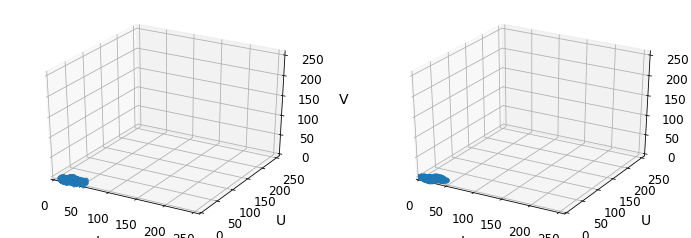

In [55]:
colourspace = "LUV"

show_3dplot(sample_vehicles[0:2], colourspace = colourspace)
show_3dplot(sample_nonvehicles[0:2], colourspace = colourspace)

*As per the samples above it shows that the car pixels correlate with higher pixel intensities than non-car images.  Given these intensity values, we should be able to create a decision boundary in hyperspace to correctly classify the images.*

#### Feature Detection Functions
Define our feature extraction / detection functions for training our classifier.

In [13]:
### Feature Extraction Functions ###
from skimage.feature import hog as hogger

# Returns the Histogram-of-Gradients for the image.
# - orient: 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if (vis):
        features, hog_image = hogger(img, orientations = orient, \
                                     pixels_per_cell = (pix_per_cell, pix_per_cell),\
                                     cells_per_block = (cell_per_block, cell_per_block),\
                                     visualise = vis, feature_vector = feature_vec)
        return (features, hog_image)
    else:
        features = hogger(img, orientations = orient, \
                          pixels_per_cell = (pix_per_cell, pix_per_cell),\
                          cells_per_block = (cell_per_block, cell_per_block),\
                          visualise = vis, feature_vector = feature_vec)
        return (features, None)

# Computes binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Computes the color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Returns: 3D tuple of feature arrays (histogram features, spatial bin features and hog features)
def extract_features(img_data, colorspace="HSV", spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256), orient = 9, 
                     pix_per_cell = 12, cell_per_block = 2, hog_channel = "ALL"):
    """ Extracts feature vectors for the given image """
    
    # convert color
    img_conv = convert_color(img_data, colorspace)

    sp_features = bin_spatial(img_conv, spatial_size)
    hist_features = color_hist(img_conv, hist_bins, hist_range)
    hog_features = []
    
    if hog_channel == 'ALL':    
        for channel in range(img_conv.shape[2]):
            (hog_feat, hg_img) = get_hog_features(img_conv[:,:,channel], orient, pix_per_cell, cell_per_block, 
                                                  vis=False, feature_vec=True)
            hog_features.append(hog_feat)
        hog_features = np.ravel(hog_features)        
    else:
        (hog_features, hg_img) = get_hog_features(img_conv[:,:,hog_channel], orient, pix_per_cell, cell_per_block, 
                                                  vis=False, feature_vec=True)
    
    return (hist_features, sp_features, hog_features)

# Returns a list of 2D tuples of the window search points
def sliding_windows(img_shape, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_shape[0]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[1]
        
    window_list = []
    
    for x in range(x_start_stop[0], x_start_stop[1], int(xy_window[0] * xy_overlap[0])):
        xv = int(x + xy_window[0])
        if (xv <= img.shape[1]):
            for y in range(y_start_stop[0], y_start_stop[1], int(xy_window[1] * xy_overlap[1])):
                yv = int(y + xy_window[1])
                if (yv <= img.shape[0]):
                    window_list.append(((x, y), (xv, yv)))
    
    return window_list

**Show extracted Histogram-of-Gradient features for each of the sample images**

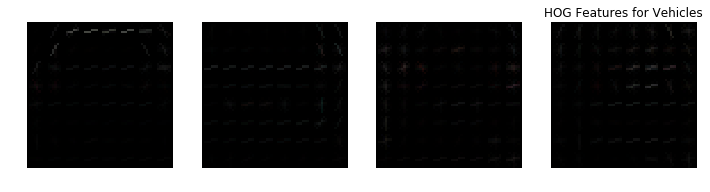

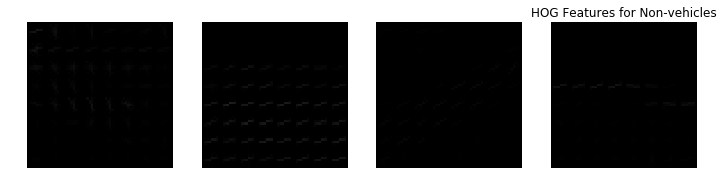

In [14]:
### Show HOG features for Samples ###

# HOG params
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"
visualise = True
as_feature_vec = False

sample_vehicle_hogs = []
for vehicle in sample_vehicles[0:4]:
    ### TODO FOR EACH CHANNEL
    hogs = np.zeros_like(vehicle)
    for channel in range(vehicle.shape[2]):
        (features, hog) = get_hog_features(vehicle[:,:,channel], orient, pix_per_cell, cell_per_block, \
                                       vis = visualise, feature_vec = as_feature_vec)
        hogs[:,:,channel] = hog
    sample_vehicle_hogs.append(hogs)

plot(sample_vehicle_hogs, 1, 4, 12., 5., title = "HOG Features for Vehicles")

sample_nonvehicle_hogs = []
for nvehicle in sample_nonvehicles[0:4]:
    hogs = np.zeros_like(vehicle)
    for channel in range(vehicle.shape[2]):
        (features, hog) = get_hog_features(nvehicle[:,:,channel], orient, pix_per_cell, cell_per_block, \
                                       vis = visualise, feature_vec = as_feature_vec)
        hogs[:,:,channel] = hog
    sample_nonvehicle_hogs.append(hogs)

plot(sample_nonvehicle_hogs, 1, 4, 12., 5., title = "HOG Features for Non-vehicles")

*As per the Histogram of Gradient results above you can see that there is a relatively distinct car image in the top row while the bottom row looks to be completely non-uniform and independent.  The current HOG feature parameters were chosen after extensive experimentation with classifiers and these proved to give the best result.*

### Preprocessing
Define our preprocessing pipeline to first load our training data search and then perform feature extraction on those images.

*Fill the files to be used in feature extraction*

In [15]:
### Search for dataset image files ###

import glob

car_image_files = [glob.glob(os.path.join(path, "*.png"), recursive=False) for path in path_vehicles]
car_image_files = np.concatenate(np.array(car_image_files))
print("Car files: [{}]\n{}".format(car_image_files.shape, car_image_files[0:5]))

noncar_image_files = [glob.glob(os.path.join(path, "*.png"), recursive=False) for path in path_nonvehicles]
noncar_image_files = np.concatenate(np.array(noncar_image_files))
print("Non-car files: [{}]\n{}".format(noncar_image_files.shape, noncar_image_files[0:5]))

Car files: [(8792,)]
['./data/vehicles/GTI_Far\\image0000.png'
 './data/vehicles/GTI_Far\\image0001.png'
 './data/vehicles/GTI_Far\\image0002.png'
 './data/vehicles/GTI_Far\\image0003.png'
 './data/vehicles/GTI_Far\\image0004.png']
Non-car files: [(8968,)]
['./data/non-vehicles/GTI\\image1.png'
 './data/non-vehicles/GTI\\image10.png'
 './data/non-vehicles/GTI\\image100.png'
 './data/non-vehicles/GTI\\image1000.png'
 './data/non-vehicles/GTI\\image1001.png']


*Extract our colour histogram features along with the spatial binning features for both classes of data*

In [16]:
### Preprocessing ###

# Feature extraction parameters
colourspace = "YUV"
spatial_size = (12, 12)
no_hist_bins = 40
hist_range = (0, 256)

# Capture features from the input images
# feature results are 3D tuples of colour histogram, spatial and hog features
car_hist, car_sp, car_hog = [], [], []
for image_file in car_image_files:
    img_data = mpimg.imread(image_file)
    (hist_feat, sp_feat, hog_feat) = extract_features(img_data, colourspace, spatial_size = spatial_size, \
                                                hist_bins = no_hist_bins, hist_range = hist_range, orient = orient, \
                                                pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,
                                                hog_channel = hog_channel)
    car_hist.append(hist_feat)
    car_sp.append(sp_feat)
    car_hog.append(hog_feat)

noncar_hist, noncar_sp, noncar_hog = [], [], []
for image_file in noncar_image_files:
    img_data = mpimg.imread(image_file)
    (hist_feat, sp_feat, hog_feat) = extract_features(img_data, colourspace, spatial_size = spatial_size, \
                                                hist_bins = no_hist_bins, hist_range = hist_range, orient = orient, \
                                                pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,
                                                hog_channel = hog_channel)
    noncar_hist.append(hist_feat)
    noncar_sp.append(sp_feat)
    noncar_hog.append(hog_feat)

# concat features into single training feature
car_features = np.column_stack((car_hist, car_sp, car_hog))
notcar_features = np.column_stack((noncar_hist, noncar_sp, noncar_hog))

### Model Design
The model architecture I've opted for to solve this classification problem is an ensemble model.  An ensemble of weak learners are trained and then voted upon by the ensemble model to yield the most confident prediction.

*Define the machine learning model to be used in the detection pipeline for the purposes of detecting vehicles within a frame*

In [17]:
# import ensemble model
from sklearn.ensemble import VotingClassifier
# import models for weak learners
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score

class Ensemble(object):
    # Default initialisation with logistic regression and linear SVM
    def __init__(self, predictors = [('svm', SVC(C=1.5, tol=1e-3, probability=False, random_state=random_state)), 
                                     ('logreg', LogisticRegression(C=1.0, tol=1e-4, random_state=random_state)),
                                     ('knn', KNeighborsClassifier(n_neighbors=10, weights='distance'))]):
        """ Initialises a new Ensemble model using the supplied predictors """
        self.predictors = predictors
        self.ensemble = VotingClassifier(estimators = self.predictors, voting = 'hard')
    
    def train(self, X, y, train_split = 0.7, folds = 10):
        """ Trains the ensemble model using stratified K folded training
            and returns the cross validated scores of each weak learner and the overall ensemble """
        
        # train and eval the models using K-fold
        scores = np.zeros((folds, len(self.predictors) + 1))
        
        fold = 0
        folding = StratifiedShuffleSplit(n_splits = folds, test_size=(1.0-train_split), random_state = random_state)
        
        for train, test in folding.split(X, y):
            X_train, y_train = X[train], y[train]
            X_test, y_test = X[test], y[test]
            
            for c in range(len(self.predictors)):
                clf = self.predictors[c][1]
                # train the classifier
                print(" - Training [{}]: X = {}, Y = {}".format(self.predictors[c][0], X_train.shape, y_train.shape))
                clf.fit(X_train, y_train)
                
                # evals the weak learner
                scores[fold, c] = f1_score(y_test, clf.predict(X_test))
            
            # train the ensemble
            print(" - Training [{}]: X = {}, Y = {}".format('voting', X_train.shape, y_train.shape))
            self.ensemble.fit(X_train, y_train)
            # evals the ensemble
            scores[fold, len(self.predictors)] = f1_score(y_test, self.ensemble.predict(X_test))
            
            fold += 1
        
        return scores
    
    def predict(self, X_test):
        """ Returns the predictions for the given sample(s) """
        return self.ensemble.predict(X_test)

*Ready the datasets by combining the car and non-car features into a single dataset for feeding into the Machine Learning model*

In [18]:
### Machine Learning model ###
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Initialise ensemble model
model = Ensemble()

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X = np.vstack((car_features, notcar_features)).astype(np.float64)

*Perform feature scaling using Z-score normalisation and then create training / test splits*

In [19]:
### Normalisation and Splitting ###
# We normalise the inputs over each column to prevent columns with different ranges from
# dominating other features

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
X = X_scaler.transform(X)

*Initialise and train the weak-learners and ensemble model to be used in the vehicle detector pipeline*

In [20]:
### Model Training ###

train_split = 0.7
kfolds = 1

print("X shape = {}".format(X.shape))
print("Y shape = {}, labels = {}".format(y.shape, np.unique(y)))

# Train an ensemble of weak learners for the different features
score = model.train(X, y, train_split = train_split, folds = kfolds)

X shape = (17760, 5844)
Y shape = (17760,), labels = [ 0.  1.]
 - Training [svm]: X = (12431, 5844), Y = (12431,)
 - Training [logreg]: X = (12431, 5844), Y = (12431,)
 - Training [knn]: X = (12431, 5844), Y = (12431,)
 - Training [voting]: X = (12431, 5844), Y = (12431,)


In [21]:
### Model Evaluation ###
print("Score:\n\n{}".format(score))

Score:

[[ 0.99084319  0.98649933  0.96392157  0.99006496]]


In [24]:
### Serialise model ###
# Training takes a while so serialise it for re-use...
import pickle

if not os.path.exists("./model/"):
    os.makedirs("./model/")
with open("./model/ensemble.p", mode="wb") as f:
    pickle.dump({ "model" : model, "scaler" : X_scaler }, f)

In [25]:
### Deserialise model ###
# Restore model from previous
import pickle
with open("./model/ensemble.p", mode="rb") as f:
    data = pickle.load(f)

model, X_scaler = data["model"], data["scaler"]

print("Loaded model.")

Loaded model.


#### Filter Functions
Define the functions used in order to filter out false positives and erroneous detections.

*Define a method for sampling bounding boxes returned from the detector and filter out random noise, or in this case, false detections.  This is done by producing a heatmap of detections which amplifies positive detections and weakens negative ones.  Afterwards, a threshold is applied to remove the weak detections.*

In [26]:
### Detection Filter Functions ###

# import labeliser function for converting heatmaps to label pixels
from scipy.ndimage.measurements import label

# Creates a heatmap using the supplied bounding boxes found in the detections
# - image_shape: Image shape
# - bbox_list: 2D tuple array of bounding boxes
def create_heatmap(image_shape, bbox_list):
    heatmap = np.zeros((image_shape[0], image_shape[1])).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Filters the heatmap based on a threshold scalar value
# - heatmap: Image heatmap of pixel intensities
# - threshold: Minimum scalar value to exceed
def threshold_heatmap(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [27]:
### Drawing functions ###

# Creates a random RGB colour between the min and max range (x, y)
randcolor = lambda x, y: (np.random.randint(x, y), np.random.randint(x, y), np.random.randint(x, y))

# Draws labeled bounding boxes
# - img: Image to draw bounding boxes onto
# - labels: Array of pixel maps to labels, where the first dimension is 
# the pixel array and the second is the label 
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], randcolor(220, 255), 4)
    # Return the image
    return img

**Define the sliding window approach combining feature extraction and vehicle detection within a given image**

In [28]:
### Vehicle detection function ###
def find_vehicles(img, ystart, ystop, scale, model, X_scaler, colourspace, orient, \
                  pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=colourspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1, hg_img = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2, hg_img = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3, hg_img = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Initialise bounding box list
    bbox_list = []
    
    # Detect vehicles
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hist_features, spatial_features, hog_features)).reshape(1,-1))    
            test_prediction = model.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # create bounding box
                bbox = [(xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)]
                # draw box
                cv2.rectangle(draw_img, bbox[0], bbox[1],(0,0,255),6) 
                bbox_list.append(bbox)
    
    # return the results
    return bbox_list, draw_img

**Show the heatmap of detections for a selection of test samples**

In [29]:
### Initialise detection params ###

window_size = 64
y_start_stop = (400, 700)
scale = 1.5

map_threshold = 0.3

*Here the heatmap threshold is chosen to best filter erroneous detections after max normalisation.  The scale has been set to 1.5 to trade-off prediction time and detection rate.*

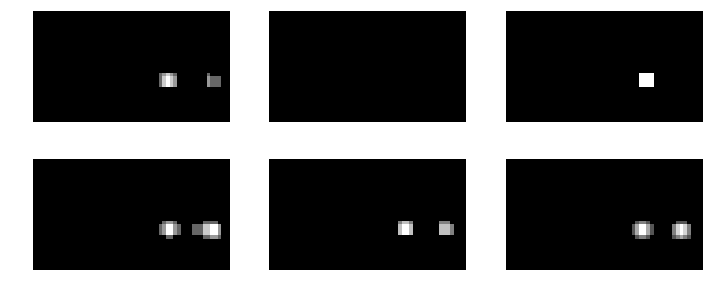

In [30]:
# Plot collection of sample images to test detection and heatmap filtering
processed_det_images = []
for img in test_images:
    # process image
    (boxes, det_img) = find_vehicles(img, ystart = y_start_stop[0], ystop = y_start_stop[1],
                                     colourspace = colourspace, scale = scale, model = model, 
                                     X_scaler = X_scaler, orient = orient, pix_per_cell = pix_per_cell, 
                                     cell_per_block = cell_per_block, spatial_size = spatial_size,
                                     hist_bins = no_hist_bins)
    heatmap = create_heatmap(det_img.shape, boxes)
    
    # normalise heatmap
    max_v = np.max(heatmap)
    if (max_v > 0):
        heatmap = heatmap / max_v
    
    # filter false vehicle detections
    heatmap = threshold_heatmap(heatmap, map_threshold)
    
    processed_det_images.append(heatmap)
    
plot(processed_det_images, 2, 3, 12., 5.)

*As per the samples above, there is no mis-classifications in the test images.  There is exactly the number of vehicles appearing as heatmap patches.*

### Final Result
Our result combines the vehicle detection pipeline defined above with our lane tracking pipeline from the previous project.  The resulting pipeline lays the foundation for feeding these sensory inputs into a master pipeline for the purposes of controlling a vehicle on the road.

In [31]:
### Import Project 4 ###
from lanetracking import Tracker, Line
# Define and calibrate our Camera object
from camera import Camera

calibration_path = "./camera_cal/"

# initialise the calibration image array
calibration_images = [mpimg.imread(os.path.join(calibration_path, x)) for x in os.listdir(calibration_path)]
dimensions = (9, 6) # init 9x6 chessboard calibration

# create Camera object and calibrate
camera = Camera()
camera.calibrate(calibration_images, dimensions)

# Prepare perspective transforms
img_size = camera.ImageSize
p_offset = 30
y_center = 440
y_margin = 60
x_margin = 320

# Define our warp source and destination coordinates
src_map = np.float32([[(img_size[0]/2.)+p_offset, y_center],  # top-right
                      [img_size[0]-(x_margin-p_offset)*1, img_size[1]-y_margin],  # bottom-right
                      [(x_margin-p_offset)*1, img_size[1]-y_margin],  # bottom-left
                      [(img_size[0]/2.)-p_offset, y_center]]) # top-left 

dst_map = np.float32([[img_size[0]-(x_margin+p_offset), 0],    # top-right
                      [img_size[0]-x_margin, img_size[1]],  # bottom-right
                      [x_margin, img_size[1]],  # bottom-left
                      [x_margin+p_offset, 0]])   # top-left

# initialise camera perspective transforms
camera.transform(src_map, dst_map)

*After calibrating the camera we can now undistort the road images to assist in vehicle detection as well as lane line detection*

**Define the image processor for detecting vehicles and lane lines within the input**

In [32]:
### Vehicle Tracking pipeline ###
class VehicleDetector(object):
    def __init__(self):
        self.prev_heatmap = None
    
    # An additive smoothing function for averaging across time steps of a heatmap
    # - heatmap1: Previous heatmap
    # - heatmap2: Current heatmap
    def smooth_heatmap(self, heatmap, eps = 1e-4):
        heatmap = np.multiply(self.prev_heatmap, heatmap) + eps
        max_v = np.max(heatmap)
        if (max_v > eps):
            heatmap = heatmap / max_v
        # cache heatmap
        self.prev_heatmap = heatmap
        
        return heatmap
    
    # Resets the cache of the vehicle detector
    def reset(self):
        self.prev_heatmap = None
    
    # Detects vehicles and returns the filtered bounding boxes
    def detect_vehicles(self, img):
        vehicle_detections, dtc_img = find_vehicles(img, ystart = y_start_stop[0], ystop = y_start_stop[1],
                                                colourspace = colourspace, scale = scale, model = model, 
                                                X_scaler = X_scaler, orient = orient, pix_per_cell = pix_per_cell, 
                                                cell_per_block = cell_per_block, spatial_size = spatial_size,
                                                hist_bins = no_hist_bins)
        # create heatmap of detections
        heatmap = create_heatmap(img.shape, vehicle_detections)
        # normalise heatmap
        max_v = np.max(heatmap)
        if (max_v > 0):
            heatmap = heatmap / max_v
        # smooth heatmap
        if (self.prev_heatmap is not None):
            heatmap = self.smooth_heatmap(heatmap)
        
        # filter false vehicle detections
        heatmap = threshold_heatmap(heatmap, map_threshold)
        heatmap_labels = label(heatmap)
        
        return heatmap_labels

*To improve the reliability of vehicle detections, an additive smoothing function has been employed to increase the confidence of detections over subsequent frames.  This works by smoothing the values of pixels across the entire image surface.*

In [33]:
import time

# init detectors
vdetector = VehicleDetector()
tracker = Tracker()

# process each video frame and return processed frame
#  - img: Image input frame
def process_image(img):
    
    undistorted = camera.undistort(img)
    
    result = undistorted
    
    result_warp = camera.warp(result)
    
    try:
        # find lanes
        (left, right) = tracker.detect_lanes(result_warp)
        
        # track the lanes
        tracker.track(left, right, max_diff = 0.01)
        
    except:
        cv2.putText(result, "Offline...", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    
    # draw and undistort the lane images
    (road_img, roadbg_img) = tracker.draw_lanes(result_warp, tracker.left_lane, tracker.right_lane)
    road_unwarped = camera.unwarp(road_img)
    roadbg_unwarped = camera.unwarp(roadbg_img)
    
    # overlay lane layers with original layer
    result = cv2.addWeighted(result, 1.0, roadbg_unwarped, 0.4, 0.0)
    result = cv2.addWeighted(result, 1.0, road_unwarped, 0.4, 0.0)
    
    # overlay vehicle detections
    vehicle_labels = vdetector.detect_vehicles(undistorted)
    # draw the vehicle detection bounding boxes
    result = draw_labeled_bboxes(result, vehicle_labels)
    
    # add stats
    vehicle_offset = tracker.center_distance(tracker.left_lane, tracker.right_lane, img.shape[1])
    offset_label = "Vehicle Offset: {:.2f}m {}".format(vehicle_offset, "Left" if vehicle_offset >= 0 else "Right")
    curve_label = "Lane Curvature: {:.2f}m".format(tracker.curvature(tracker.left_lane, tracker.right_lane))
    
    # add statistic labels
    stats = np.copy(result)
    cv2.rectangle(stats, (20,img.shape[0]-150), (520, img.shape[0]-20), color=(1,1,1), thickness=-1)
    result = cv2.addWeighted(result, 0.4, stats, 0.6, -1.0)
    cv2.putText(result, offset_label, (50,img.shape[0]-50), cv2.FONT_HERSHEY_SIMPLEX, 1, (220,220,220), 2)
    cv2.putText(result, curve_label, (50,img.shape[0]-100), cv2.FONT_HERSHEY_SIMPLEX, 1, (220,220,220), 2)
    
    return result

**Show sample frames to prove the entire detection and lane line tracking pipeline is working correctly**

C:\Users\palladium\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\palladium\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\palladium\Documents\Source\Repos\CarND-Vehicle-Detection\lanefinding.py:127: RuntimeWarning: invalid value encountered in true_divide
  return X / np.sum(X, axis=0)
C:\Users\palladium\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\palladium\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\palladium\AppData\Loc

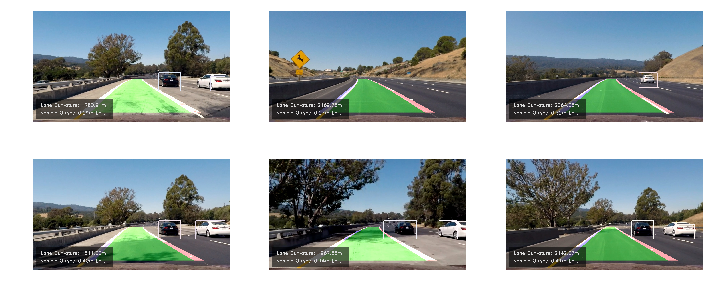

In [34]:
processed_test_images = []
for img in test_images:
    # process image
    proc_img = process_image(img)
    tracker.reset() # prevent smoothing across static frames
    vdetector.reset() # prevent caching across static frames
    
    processed_test_images.append(proc_img)
    
plot(processed_test_images, 2, 3, 12., 5.)

**Process the frames from the video and create the output result**

In [35]:
### Import Video Processors ###
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [36]:
### Process video ###
easy_output = 'project_proc.mp4'
clip_easy = VideoFileClip("project_video.mp4", audio=False)
easy_clip = clip_easy.fl_image(process_image)
%time easy_clip.write_videofile(easy_output, audio=False)

[MoviePy] >>>> Building video project_proc.mp4
[MoviePy] Writing video project_proc.mp4


100%|██████████████████████████████████████████████████████████████████████████▉| 1260/1261 [22:14:19<01:03, 63.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_proc.mp4 

Wall time: 22h 14min 20s


In [37]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(easy_output))

### Reflection
This project was excellent to see the final result of applying lane line detection as well as vehicle detection.  The vehicle detector seems to work really well with very minimal false positives.  The detector also stayed within the current lanes and skipped vehicles in the adjacent section of the highway which is beneficial to building up a local map of the car's environment.  If it were to detect these cars approaching at 2x speed, the system would most likely engage emergency braking and cause an accident.

One pitfall of this vehicle detector is that it misses cars too far away.  This is due to the sliding window routine and could be improved by scaling the window with respect to the depth.  Given more time this could be improved easily..

Another hypothetical issue is that it was only trained on images of cars so it will most likely fail to detect motorbikes and trucks.  I would also be interested to test its ability on detecting highly modified vehicles such as fancy ice-cream trucks to see the result.